## Relation between DoS and Receptive Field

This notebook calculates the degrees of separation and receptive fields
for DUD-E ligands and proteins stored in the PyTorch `Data` format.

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import heapq
import csaps
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from progressbar import progressbar
from torch_geometric.data import Data

<IPython.core.display.Javascript object>

### Function definitions

#### Loading data

In [3]:
def process_data(data):
    """Convert the Data to the dictionary graph representation, and bond list."""
    edge_indices = data.edge_index.numpy()
    graph_dict = dict()
    # For each vertex in the graph, create a dictionary in graph_dict.
    for i in range(data.x.shape[0]):
        graph_dict[i] = dict()
    # For each edge, record it in graph_dict. In our use case,
    # the weight of each bond is "1", although this notebook can be used
    # otherwise.
    # Additionally, record all the bonds in a list of pairs.
    bonds = []
    for i in range(len(edge_indices[0])):
        graph_dict[edge_indices[0][i]][edge_indices[1][i]] = 1
        bonds.append([edge_indices[0][i], edge_indices[1][i]])
    return graph_dict, bonds


def load_ligands(target, sample):
    """Get the ligand graph dictionaries and bonds relating to the target."""
    target_data_dict = pd.read_pickle(f"../data/raw/{target}_ligand_dict.pkl")
    # If sampling, randomly select only "sample" of the lignds
    # associated with the target.
    if sample is not None:
        selected_ligands = np.random.choice(
            list(target_data_dict.keys()), size=sample, replace=False
        )
    else:
        selected_ligands = target_data_dict.keys()
    return {
        ligand_code: process_data(ligand_data)
        for ligand_code, ligand_data in target_data_dict.items()
        if ligand_code in selected_ligands
    }


def load_target(target, protein_cutoff=10, bond_mode="bond_cutoff", bond_cutoff=5):
    """Get the protein graph's dictionary and bonds."""
    target_data = pd.read_pickle(
        f"../data/raw/{protein_cutoff}_{bond_mode}_{bond_cutoff}_{target}.pkl"
    )
    return process_data(target_data)

<IPython.core.display.Javascript object>

#### Getting DoSes

In [4]:
# get_distances_vertex implementation from
# https://bradfieldcs.com/algos/graphs/dijkstras-algorithm/
# Retrieved and modified on 17/12/2020.


def get_distances_vertex(graph, starting_vertex, filter_natural=False):
    """Get the shortest distances from the starting vertex to every other."""
    # Initialize all distances as infinity, except for that between the
    # starting vertex and itself.
    distances = {vertex: float("infinity") for vertex in graph}
    distances[starting_vertex] = 0

    # Initialize the priority queue with the vertex we start the path from.
    pq = [(0, starting_vertex)]
    while len(pq) > 0:
        # Pop out the "most promising" vertex to next visit.
        current_distance, current_vertex = heapq.heappop(pq)

        # Nodes can get added to the priority queue multiple times. We only
        # process a vertex the first time we remove it from the priority queue.
        if current_distance > distances[current_vertex]:
            continue

        # Consider visiting the neighbors of the current vertex in consideration.
        for neighbor, weight in graph[current_vertex].items():
            distance = current_distance + weight

            # Only consider this new path if it's better than any path we've
            # already found.
            if distance < distances[neighbor]:
                # Update the shortest distance to this neighbor.
                distances[neighbor] = distance
                heapq.heappush(pq, (distance, neighbor))

    # Filter out all infinite distance entries (i.e., the vertex isn't reachable
    # from starting_vertex), and the entry for the starting_vertex itself.
    if filter_natural:
        return {
            vertex: distance
            for vertex, distance in distances.items()
            if vertex != starting_vertex and not np.isinf(distance)
        }
    return {
        vertex: distance
        for vertex, distance in distances.items()
        if vertex != starting_vertex
    }

<IPython.core.display.Javascript object>

In [5]:
def get_distances_all(graph):
    """Get the shortest distances towards every vertex in the graph from every other."""
    all_distances = []
    for i in range(len(graph.keys())):
        all_distances.append(get_distances_vertex(graph, i))
    # This is a list of dictionaries of length of the number of atoms
    # in the graph.
    return all_distances

<IPython.core.display.Javascript object>

In [6]:
def get_ligand_distances(target_data_dict):
    """Get vertex-vertex shortest distances for each ligand for the target."""
    # This dictionary is of the form str : list of dicts.
    return {
        ligand_code: get_distances_all(processed_ligand_data[0])
        for ligand_code, processed_ligand_data in target_data_dict.items()
    }


def get_mean_dos_ligand(subdict_list):
    return np.mean([np.mean(list(subdict.values())) for subdict in subdict_list])


def get_target_distances(target_graph):
    pass

<IPython.core.display.Javascript object>

#### Receptive field

In [7]:
def get_receptive_fields_ligand(num_atoms, chemical_bonds):
    """Get the receptive field proportion path for each atom."""
    # Create the dictionary of chemical bonds of the form
    # key atom -> each atom in the value dict.
    chemical_bonds_dict = dict()
    for i in range(len(chemical_bonds)):
        try:
            chemical_bonds_dict[chemical_bonds[i][0]].append(chemical_bonds[i][1])
        except:
            chemical_bonds_dict[chemical_bonds[i][0]] = [chemical_bonds[i][1]]

    # Create a list of lists of length num_atoms. Each sublist
    # describes the receptive field proportion as the graph power
    # is increased, corresponding to the index in the sublist.
    all_rf_prop_paths = []
    for atom_index in range(num_atoms):
        all_rf_prop_paths.append([])
        # The list of all neighbors of the atom, after graph power.
        all_neighbors = []
        # The atoms whose neighbors we will consider in the next
        # graph power. We initialize this list with the immediate
        # neighbors.
        neighbors_to_explore = chemical_bonds_dict[atom_index]
        while True:
            # The set of immediate neighbors of the neighbors to explore.
            new_neighbors = set()
            for neighbor_atom_index in neighbors_to_explore:
                new_neighbors.update(chemical_bonds_dict[neighbor_atom_index])
            # Add the explored neighbors to all_neighbors, and remove duplicates.
            all_neighbors += neighbors_to_explore
            all_neighbors = list(set(all_neighbors))
            # The neighbors to now explore are the neighbors just found.
            neighbors_to_explore = list(new_neighbors)
            # Get the receptive field proportion.
            curr_rf_prop = len(all_neighbors) / num_atoms
            # If there are no new neighbors found, break out of the loop.
            # This will occur if:
            # 1. The RF proportion is 1, or
            # 2. only isolated nodes are left unreached.
            try:
                if all_rf_prop_paths[atom_index][-1] == curr_rf_prop:
                    break
            except:
                pass
            all_rf_prop_paths[atom_index].append(curr_rf_prop)
    return all_rf_prop_paths

<IPython.core.display.Javascript object>

In [8]:
def get_init_rf_props_ligand(all_rf_prop_paths):
    """Get the initial average RF proportion for the ligand."""
    return np.mean([path[0] for path in all_rf_prop_paths])


def get_avg_full_len_ligand(all_rf_prop_paths):
    """Get the average full RF proportion power for the ligand."""
    return np.mean([len(path) for path in all_rf_prop_paths])


def get_receptive_fields_target(target_data_dict):
    """Get each vertex's receptive field path for each ligand for the target."""
    # Dictionary of the form ligand code: each vertex's RF proportion path.
    rf_paths_dict = {
        ligand_code: get_receptive_fields_ligand(
            len(processed_ligand_data[0]), processed_ligand_data[1]
        )
        for ligand_code, processed_ligand_data in target_data_dict.items()
    }
    # Return also the average initial RF proportion of each ligand, and
    # the number of
    return (
        rf_paths_dict,
        {
            ligand_code: get_init_rf_props_ligand(all_rf_prop_paths)
            for ligand_code, all_rf_prop_paths in rf_paths_dict.items()
        },
        {
            ligand_code: get_avg_full_len_ligand(all_rf_prop_paths)
            for ligand_code, all_rf_prop_paths in rf_paths_dict.items()
        },
    )


def get_average_path_ligand(rf_paths):
    """Get average RF proportion for each graph power."""

    def pad(path):
        return path + [path[-1]] * (max_path_len - len(path))

    max_path_len = np.max([len(path) for path in rf_paths])
    rf_paths = np.array([pad(path) for path in rf_paths])
    return rf_paths.mean(0).tolist()

<IPython.core.display.Javascript object>

#### Plotting

In [35]:
def plot_histogram(x, xlabel, title):
    n, bins, patches = plt.hist(
        x=x, bins="auto", color="#0504aa", alpha=0.7, rwidth=0.85
    )
    plt.grid(axis="y", alpha=0.75)
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")
    plt.title(title)
    plt.axvline(x=np.mean(x), color="red", linestyle="--")
    maxfreq = n.max()
    plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)


def plot_relationship(x, y, xlabel, ylabel, title="", show_spline=True):
    if not show_spline:
        plt.plot(x, y, "o", color="#0504aa")
    else:
        smoothing_spline = csaps.CubicSmoothingSpline(x, y, smooth=0.85)
        x_inputs = np.linspace(np.min(x), np.max(x), 150)
        y_outputs = smoothing_spline(x_inputs)
        plt.plot(x, y, "o", x_inputs, y_outputs, "-", color="#0504aa")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

<IPython.core.display.Javascript object>

### Application

In [10]:
# Get the list of target names.
all_targets = pd.read_csv("../data/dud-e_targets.csv").target_name.tolist()
all_targets = [target.lower() for target in all_targets]

# Temporary removal -- bond information not available.
all_targets.remove("aa2ar")
all_targets.remove("drd3")

<IPython.core.display.Javascript object>

#### Ligands

In [11]:
PRELOAD = 1

<IPython.core.display.Javascript object>

In [12]:
if PRELOAD:
    all_ligand_data_dicts = pd.read_pickle("all_ligand_data_dicts.pkl")
else:
    np.random.seed(1)
    all_ligand_data_dicts = dict()
    for target in progressbar(all_targets):
        all_ligand_data_dicts[target] = load_ligands(target, 400)
    with open("all_ligand_data_dicts.pkl", "wb") as f:
        pickle.dump(
            all_ligand_data_dicts,
            f,
        )

<IPython.core.display.Javascript object>

In [13]:
if PRELOAD:
    all_ligand_dos = pd.read_pickle("all_ligand_dos.pkl")
else:
    all_ligand_dos = []
    for target in progressbar(all_targets):
        curr_ligand_distance_dict = get_ligand_distances(all_ligand_data_dicts[target])
        all_ligand_dos += [
            get_mean_dos_ligand(subdict_list)
            for subdict_list in curr_ligand_distance_dict.values()
        ]
    with open("all_ligand_dos.pkl", "wb") as f:
        pickle.dump(
            all_ligand_dos,
            f,
        )

<IPython.core.display.Javascript object>

In [15]:
if PRELOAD:
    all_ligand_rf_paths = pd.read_pickle("all_ligand_rf_paths.pkl")
    all_ligand_avg_rf = pd.read_pickle("all_ligand_avg_rf.pkl")
    all_ligand_full_lens = pd.read_pickle("all_ligand_full_lens.pkl")
else:
    all_ligand_rf_paths = []
    all_ligand_avg_rf = []
    all_ligand_full_lens = []
    for target in progressbar(all_targets):
        rf_paths_dict, init_rf_props, avg_full_lens = get_receptive_fields_target(
            all_ligand_data_dicts[target]
        )
        all_ligand_rf_paths += [
            get_average_path_ligand(rf_paths) for rf_paths in rf_paths_dict.values()
        ]
        all_ligand_avg_rf += list(init_rf_props.values())
        all_ligand_full_lens += list(avg_full_lens.values())
    all_ligand_rf_paths = get_average_path_ligand(all_ligand_rf_paths)

    with open("all_ligand_avg_rf.pkl", "wb") as f:
        pickle.dump(
            all_ligand_avg_rf,
            f,
        )
    with open("all_ligand_rf_paths.pkl", "wb") as f:
        pickle.dump(
            all_ligand_rf_paths,
            f,
        )
    with open("all_ligand_full_lens.pkl", "wb") as f:
        pickle.dump(
            all_ligand_full_lens,
            f,
        )

100% (100 of 100) |######################| Elapsed Time: 0:03:56 Time:  0:03:56


<IPython.core.display.Javascript object>

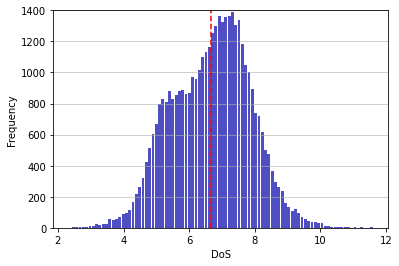

<IPython.core.display.Javascript object>

In [41]:
plot_histogram(all_ligand_dos, "DoS", "")

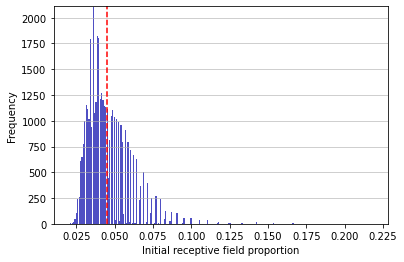

<IPython.core.display.Javascript object>

In [48]:
plot_histogram(all_ligand_avg_rf, "Initial receptive field proportion", "")

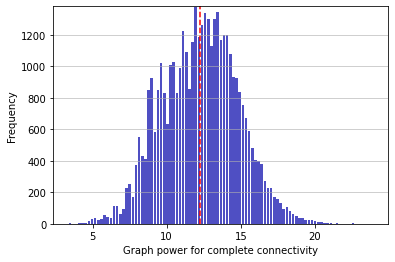

<IPython.core.display.Javascript object>

In [42]:
plot_histogram(all_ligand_full_lens, "Graph power for complete connectivity", "")

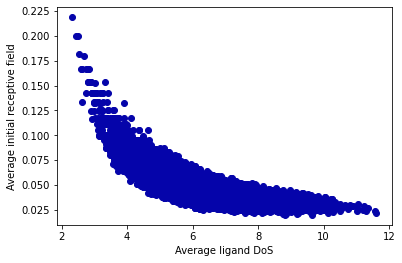

<IPython.core.display.Javascript object>

In [47]:
plot_relationship(
    np.array(all_ligand_dos)[np.argsort(all_ligand_dos)],
    np.array(all_ligand_avg_rf)[np.argsort(all_ligand_dos)],
    "Average ligand DoS",
    "Average initial receptive field",
    show_spline=0,
)

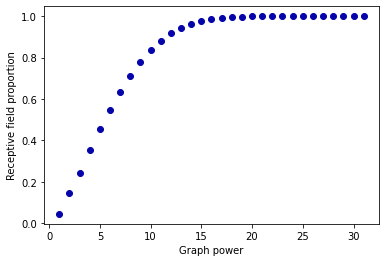

<IPython.core.display.Javascript object>

In [40]:
plot_relationship(
    list(range(1, len(all_ligand_rf_paths) + 1)),
    all_ligand_rf_paths,
    "Graph power",
    "Receptive field proportion",
    show_spline=False,
)

#### Proteins

TBD